In [1]:
### Package Imports ###
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import shap 

In [2]:
### Data Import ###
data = pd.read_csv('./data/Telco-Customer-Churn.csv', na_values=[' '])

### Pre-Processing ###
# Drop NaN rows
data = data.dropna(axis=0)

# Map gender column to binary values
gender_mapping = {'Male': 1, 'Female': 0}
data['gender'] = data['gender'].map(lambda x: 1 if x == 'Male' else 0)

# Map "No internet service" to "No"
internet_services_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data[internet_services_columns] = data[internet_services_columns].map(lambda x: "No" if x == "No internet service" else x)

# Map No to 0 and Yes to 1
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] + internet_services_columns
data[yes_no_columns] = data[yes_no_columns].map(lambda x: 0 if x == "No" else 1)

# Change TotalCharges dtype
data['TotalCharges'] = data['TotalCharges'].astype(float)

# Reformat PaymentMethod column
payment_method_mapping = {'Bank transfer (automatic)': 'BankTransfer', 'Credit card (automatic)': 'CreditCard', 'Electronic check': 'ElectronicCheck', 'Mailed check': 'MailedCheck'}
data['PaymentMethod'] = data['PaymentMethod'].replace(payment_method_mapping)

# Reformat Contract column
contract_mapping = {'Month-to-month': 'MonthToMonth', 'One year': 'OneYear', 'Two year': 'TwoYear'}
data['Contract'] = data['Contract'].map(contract_mapping)

# Reformat InternetService column
internet_service_mapping = {'Fiber optic': 'FiberOptic'}
data['InternetService'] = data['InternetService'].map(internet_service_mapping)

In [3]:
### XGBoost Algorithm ### 
# Splitting the data into train and test sets
X = data.drop(['customerID','Churn'], axis=1)  # Features
y = data['Churn']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform one-hot encoding for categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7981520966595593


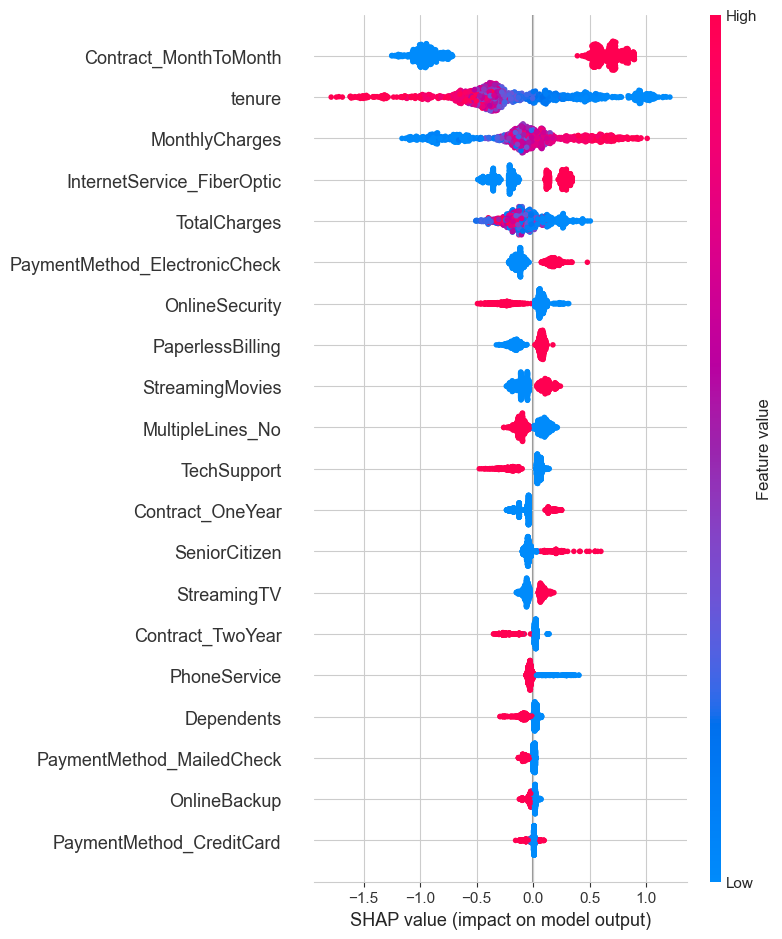

In [4]:
### Model Explanation using Shapley Values ###
# Initialize an explainer with the best model's predict method
explainer = shap.Explainer(best_model)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_encoded)